In [1]:
import copy

# Importing necessary libraries
import pandas as pd
import numpy as np
import datetime


In [2]:
# Load the dataset and preprocess
df = pd.read_csv("preprocessed_dataset.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [3]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:03:00,56.39,13.53,2082.27,391.733,403.738,9.70067,1.74925,250.509,251.163,250.610,...,250.389,249.430,606.023,596.422,604.776,437.700,430.352,433.920,443.036,1.40
2017-03-10 01:03:20,55.20,16.98,3019.53,557.434,395.713,10.06640,1.74000,249.214,253.235,250.576,...,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,1.31
2017-03-10 01:03:40,55.20,16.98,3024.41,563.965,397.383,10.06720,1.74000,249.719,250.532,250.862,...,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,1.31
2017-03-10 01:04:00,55.20,16.98,3043.46,568.054,399.668,10.06800,1.74000,249.741,247.874,250.313,...,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,1.31
2017-03-10 01:04:20,55.20,16.98,3047.36,568.665,397.939,10.06890,1.74000,249.917,254.487,250.049,...,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,1.31


#### Interpolate hourly variables
#### Not used now, we use the window averaging inside the PLS loop

In [5]:
# Hourly changed variables: Iron Feed, Silica Feed, Silica Concentrate
iron_feed = df["% Iron Feed"]
silica_feed = df["% Silica Feed"]
silica_concentrate = df["% Silica Concentrate"]

minutes = iron_feed.index.minute.to_numpy()
seconds = iron_feed.index.second.to_numpy()

df["% Iron Feed"] = iron_feed.where(minutes + seconds == 0)
df["% Silica Feed"] = silica_feed.where(minutes + seconds == 0)
df["% Silica Concentrate"] = silica_concentrate.where(minutes + seconds == 0)

df = df.interpolate(method='polynomial', order=3)
df = df.dropna()
df

#### PLS loop

In [233]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from model import Model
from sklearn.metrics import mean_squared_error, r2_score, f1_score
import progressbar  # pip install progressbar2
import copy
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

def q2_score(Y, y_t, y_fit_t):
    tss_res = np.sum((np.array(Y) - np.mean(Y))**2)
    press = np.sum((np.array(y_t) - np.array(y_fit_t))**2)
    return 1. - press / tss_res

df_array = df.to_numpy()
print(df_array.shape)

# Reduce the amount of observations (with averaging)
df = df.resample("H").mean()

included_rows1 = [df.index.get_loc(datetime.datetime(2017, 4, 23, 19, 0, 00)),
                    df.index.get_loc(datetime.datetime(2017, 5, 13, 0, 0, 00))]
included_rows2 = [df.index.get_loc(datetime.datetime(2017, 6, 15, 1, 0, 00)),
                    df.index.get_loc(datetime.datetime(2017, 7, 24, 0, 0, 00))]
included_rows3 = [df.index.get_loc(datetime.datetime(2017, 8, 15, 1, 0, 00)),
                    df.index.get_loc(datetime.datetime(2017, 9, 10, 0, 0, 00))]
excluded_rows1 = [2950, 3165]

df_array = df.to_numpy()
print(df_array.shape)

models = []
max_comp_num = 10
windows = [6, 12, 16, 32, 64, 128]  # [4, 7, 10, 14, 20, 26, 33]

print(df)


(737454, 22)
(4416, 22)
                     % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
date                                                                       
2017-03-10 01:00:00    55.206959      16.959825  3156.865114  578.517076   
2017-03-10 02:00:00    55.200000      16.980000  3127.690444  536.664244   
2017-03-10 03:00:00    55.200000      16.980000  3479.749500  591.474244   
2017-03-10 04:00:00    55.200000      16.980000  3233.696103  592.659950   
2017-03-10 05:00:00    55.200000      16.980000  3324.578906  619.395461   
...                          ...            ...          ...         ...   
2017-09-09 20:00:00    49.750000      23.200000  4231.042444  508.729783   
2017-09-09 21:00:00    49.750000      23.200000  2807.611136  517.808106   
2017-09-09 22:00:00    49.750000      23.200000  3192.763506  492.756450   
2017-09-09 23:00:00    49.750000      23.200000  3649.241708  460.780383   
2017-09-10 00:00:00    49.750000      23.200000  1164.120000  46

In [234]:
import math
from smt.surrogate_models import KPLS

def average_window(column):
    return np.zeros(column.shape) + np.average(column, axis=0)

# Find best window_size and num_of_components
for window_size in progressbar.progressbar(windows):  # [10, 20, 30, ...]
        # Division of data into training, validation and test sets for the normal functioning times:
        # about 70% for training, 15% for validation, 15% for testing
        test_size = math.ceil(0.25 * window_size)
        test_start = '2017-04-23 20:00:00' # example start of test partition
        test_start = datetime.datetime.strptime(test_start, '%Y-%m-%d %H:%M:%S')

        # Models with same window size (they all take the same windows, no need to get them multiple times...)
        models_one_win_size = [Model((window_size, i), [], []) 
                               for i in range(1, max_comp_num)]
        print("Start...")
        flag = 0
        iteration_count = 0
        row_number = df.index.get_loc(test_start)
        ls = []
        # Iterate through the data
        while flag == 0:
            
            iteration_count += 1
            if iteration_count % 1000 == 0:    
                print(iteration_count)
                
            test_data, training_data = None, None
            test_y_end = row_number + test_size + 1
            training_X_start = row_number - math.ceil(0.75 * window_size)
            
            # Stay within included rows
            if ((test_y_end <= included_rows1[1] and training_X_start - 2 >= included_rows1[0])
                or (test_y_end <= included_rows2[1] and training_X_start - 2 >= included_rows2[0])
                or (test_y_end <= included_rows3[1] and training_X_start - 2 >= included_rows3[0])) \
                and (training_X_start - 2 > excluded_rows1[1] or test_y_end < excluded_rows1[0]):  # Error part of dataset exclude !!!

                # Test set
                test_X_lag1 = df_array[row_number:test_y_end-1,:-1]
                test_X = np.hstack((test_X_lag1,  # test_X_lag2, test_X_lag3, 
                                    np.expand_dims(df_array[row_number:test_y_end-1,-1], 1),
                                    np.expand_dims(df_array[row_number-1:test_y_end-2,-1], 1),
                                    np.expand_dims(df_array[row_number-2:test_y_end-3,-1], 1)))  # test_X_lag1
                
                test_y = df_array[row_number+1:test_y_end,-1]

                # Training set
                training_X_lag1 = df_array[training_X_start:row_number,:-1]
                
                training_X = np.hstack((training_X_lag1,  # training_X_lag2, training_X_lag3,
                                        np.expand_dims(df_array[training_X_start:row_number,-1], 1),
                                        np.expand_dims(df_array[training_X_start-1:row_number-1,-1], 1),
                                        np.expand_dims(df_array[training_X_start-2:row_number-2,-1], 1)))  # training_X_lag1
                
                training_y = df_array[training_X_start+1:row_number+1,-1]

                # Lagged predictor variables and the response variable in one matrix
                test_data = np.column_stack([test_X, test_y])
                training_data = np.column_stack([training_X, training_y])

                flag = 1 if test_y_end == included_rows3[1] else 0
            else:
                    flag = 1 if test_y_end > included_rows3[1] else 0    
            row_number += 1
            
            ######################    
            # Data window generated, all models here have same window size, only different num of components...
            if test_data is None or training_data is None or np.all(test_data[:, :-1] == 0.):
                continue
  
            for model in models_one_win_size:
                if math.ceil(0.75 * model.window_size) <= model.num_components:
                    continue
                train_win_X = np.array(training_data[:, :-1])
                train_win_y = np.expand_dims(np.array(training_data[:, -1]), 1)
                
                sm = KPLS(eval_n_comp=False, print_global=False, n_comp=model.num_components)
                sm.set_training_values(train_win_X, train_win_y)
                sm.train()
                
                test_win_X = test_data[:, :-1]
                test_win_y = np.expand_dims(np.array(test_data[:, -1]), 1)
                
                y_test_pred = sm.predict_values(test_win_X)
                y_train_pred = sm.predict_values(train_win_X)
                
                model.test_metrics[0].append(mean_squared_error(test_win_y, y_test_pred))
                model.test_metrics[1].append(q2_score(train_win_y, test_win_y, y_test_pred))
    
                model.train_metrics[0].append(mean_squared_error(train_win_y, y_train_pred))
                model.train_metrics[2].append(r2_score(train_win_y, y_train_pred))
                
                model.model.append(sm)
            
        models.extend(models_one_win_size)
        # print(ls)
        
        for model in models_one_win_size:
            print(f"Saving model with window size: {model.window_size} and No. component: {model.num_components}...")
            # print(model.model[-1].coef_)
            dump(model, f"{model.window_size}_{model.num_components}_model.joblib")


  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

Start...
1000
2000
3000
Saving model with window size: 6 and No. component: 1...
Saving model with window size: 6 and No. component: 2...
Saving model with window size: 6 and No. component: 3...
Saving model with window size: 6 and No. component: 4...


 16% (1 of 6) |####                      | Elapsed Time: 0:06:25 ETA:   0:32:06

Saving model with window size: 6 and No. component: 5...
Saving model with window size: 6 and No. component: 6...
Saving model with window size: 6 and No. component: 7...
Saving model with window size: 6 and No. component: 8...
Saving model with window size: 6 and No. component: 9...
Start...
1000
2000
3000
Saving model with window size: 12 and No. component: 1...
Saving model with window size: 12 and No. component: 2...
Saving model with window size: 12 and No. component: 3...
Saving model with window size: 12 and No. component: 4...
Saving model with window size: 12 and No. component: 5...
Saving model with window size: 12 and No. component: 6...
Saving model with window size: 12 and No. component: 7...
Saving model with window size: 12 and No. component: 8...


 33% (2 of 6) |########                  | Elapsed Time: 0:26:55 ETA:   1:22:01

Saving model with window size: 12 and No. component: 9...
Start...
1000
2000
3000
Saving model with window size: 16 and No. component: 1...
Saving model with window size: 16 and No. component: 2...
Saving model with window size: 16 and No. component: 3...
Saving model with window size: 16 and No. component: 4...
Saving model with window size: 16 and No. component: 5...
Saving model with window size: 16 and No. component: 6...
Saving model with window size: 16 and No. component: 7...
Saving model with window size: 16 and No. component: 8...
Saving model with window size: 16 and No. component: 9...


 50% (3 of 6) |#############             | Elapsed Time: 0:52:32 ETA:   1:16:50

Start...
1000
2000
3000
Saving model with window size: 32 and No. component: 1...
Saving model with window size: 32 and No. component: 2...
Saving model with window size: 32 and No. component: 3...
Saving model with window size: 32 and No. component: 4...
Saving model with window size: 32 and No. component: 5...
Saving model with window size: 32 and No. component: 6...
Saving model with window size: 32 and No. component: 7...
Saving model with window size: 32 and No. component: 8...
Saving model with window size: 32 and No. component: 9...


 66% (4 of 6) |#################         | Elapsed Time: 1:21:15 ETA:   0:57:24

Start...
1000
2000
3000
Saving model with window size: 64 and No. component: 1...
Saving model with window size: 64 and No. component: 2...
Saving model with window size: 64 and No. component: 3...
Saving model with window size: 64 and No. component: 4...
Saving model with window size: 64 and No. component: 5...
Saving model with window size: 64 and No. component: 6...
Saving model with window size: 64 and No. component: 7...
Saving model with window size: 64 and No. component: 8...
Saving model with window size: 64 and No. component: 9...


 83% (5 of 6) |#####################     | Elapsed Time: 1:54:23 ETA:   0:33:08

Start...
1000
2000
3000
Saving model with window size: 128 and No. component: 1...
Saving model with window size: 128 and No. component: 2...
Saving model with window size: 128 and No. component: 3...
Saving model with window size: 128 and No. component: 4...
Saving model with window size: 128 and No. component: 5...
Saving model with window size: 128 and No. component: 6...
Saving model with window size: 128 and No. component: 7...
Saving model with window size: 128 and No. component: 8...
Saving model with window size: 128 and No. component: 9...


100% (6 of 6) |##########################| Elapsed Time: 2:40:12 Time:  2:40:12


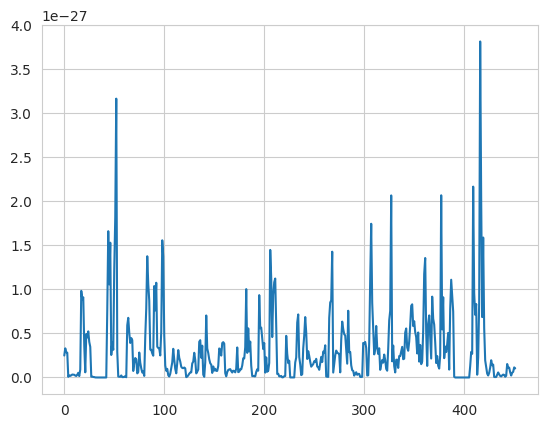

In [222]:
import matplotlib.pyplot as plt

plt.plot(range(len(models[0].train_metrics[0])), 
         models[0].train_metrics[0])
plt.show()

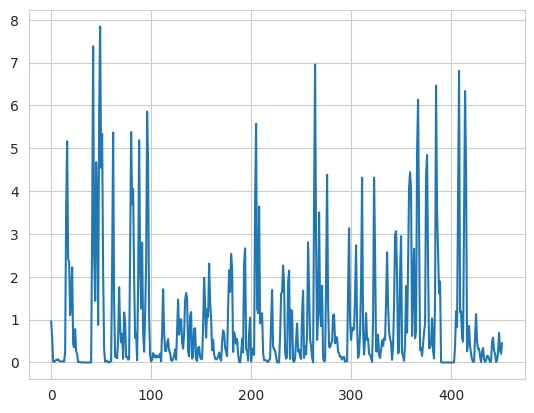

(array([], dtype=int64),)


In [227]:
mse = np.array(models[47].test_metrics[0])
plt.plot(range(mse.shape[0]), 
         mse)
plt.show()
print(np.where(np.array(models[11].test_metrics[0]) > 10))

In [200]:
models = []
mses = []
for win_size in windows:
    for i in range(1, max_comp_num):
        models.append(load(f"{win_size}_{i}_model.joblib"))
        mses.append(models[-1].test_metrics)


In [9]:
model_loaded = load("10_2_model.joblib")

1.0
1.0
1.0
1.0
nan
nan
nan
nan
nan
0.9999999999999991
1.0
1.0
1.0
1.0
1.0
1.0
1.0
nan
0.9999999999999969
0.9999999999999988
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999607
0.9999999999999946
0.9999999999999951
0.9999999999999981
0.9999999999999996
0.9999999999999998
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


[Text(158.22222222222223, 0.5, 'Window Size'),
 Text(0.5, 58.7222222222222, 'No. Latent Variables')]

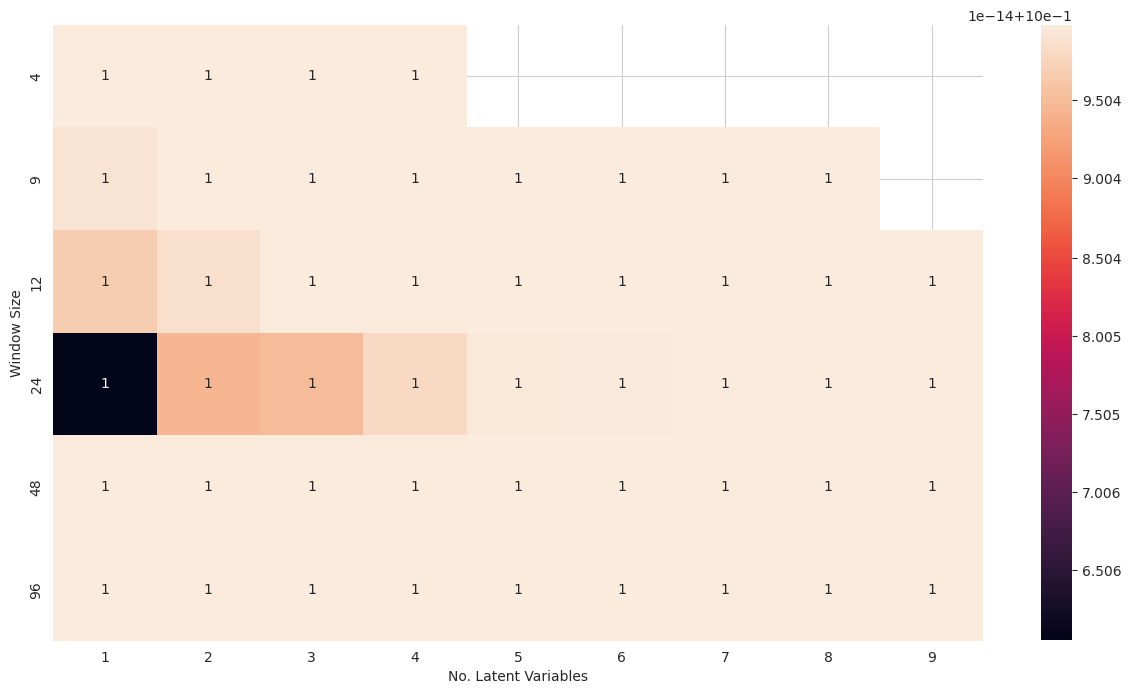

In [235]:
from seaborn import heatmap
from matplotlib.axes import Axes

metrics = np.zeros((len(windows), max_comp_num - 1))
for model in models:
    metric = np.array(model.train_metrics[2])
    metrics[windows.index(model.window_size), model.num_components - 1] = np.mean(metric)
    print(np.mean(metric))

fig, _ = plt.subplots(figsize=(15, 8))
ax = heatmap(metrics, annot=True, xticklabels=range(1, max_comp_num), yticklabels=(np.array(windows) * 0.75).astype(int))
ax.set(ylabel="Window Size", xlabel="No. Latent Variables")

In [ ]:
metrics = np.zeros((len(windows), max_comp_num - 1))
for model in models:
    metric = np.array(model.train_metrics[1])
    metric = metric[~np.isnan(metric)]
    metric = metric[metric >= 0.]
    metric = metric[metric <= 1.]
    metrics[windows.index(model.window_size), model.num_components - 1] = np.mean(metric)
    print(np.mean(metric))

fig, _ = plt.subplots(figsize=(15, 8))
ax = heatmap(metrics, annot=True, xticklabels=range(1, max_comp_num), yticklabels=(np.array(windows) * 0.75).astype(int))
ax.set(ylabel="Window Size", xlabel="No. Latent Variables")

[Text(283.22222222222223, 0.5, 'Window Size'),
 Text(0.5, 58.7222222222222, 'No. Latent Variables')]

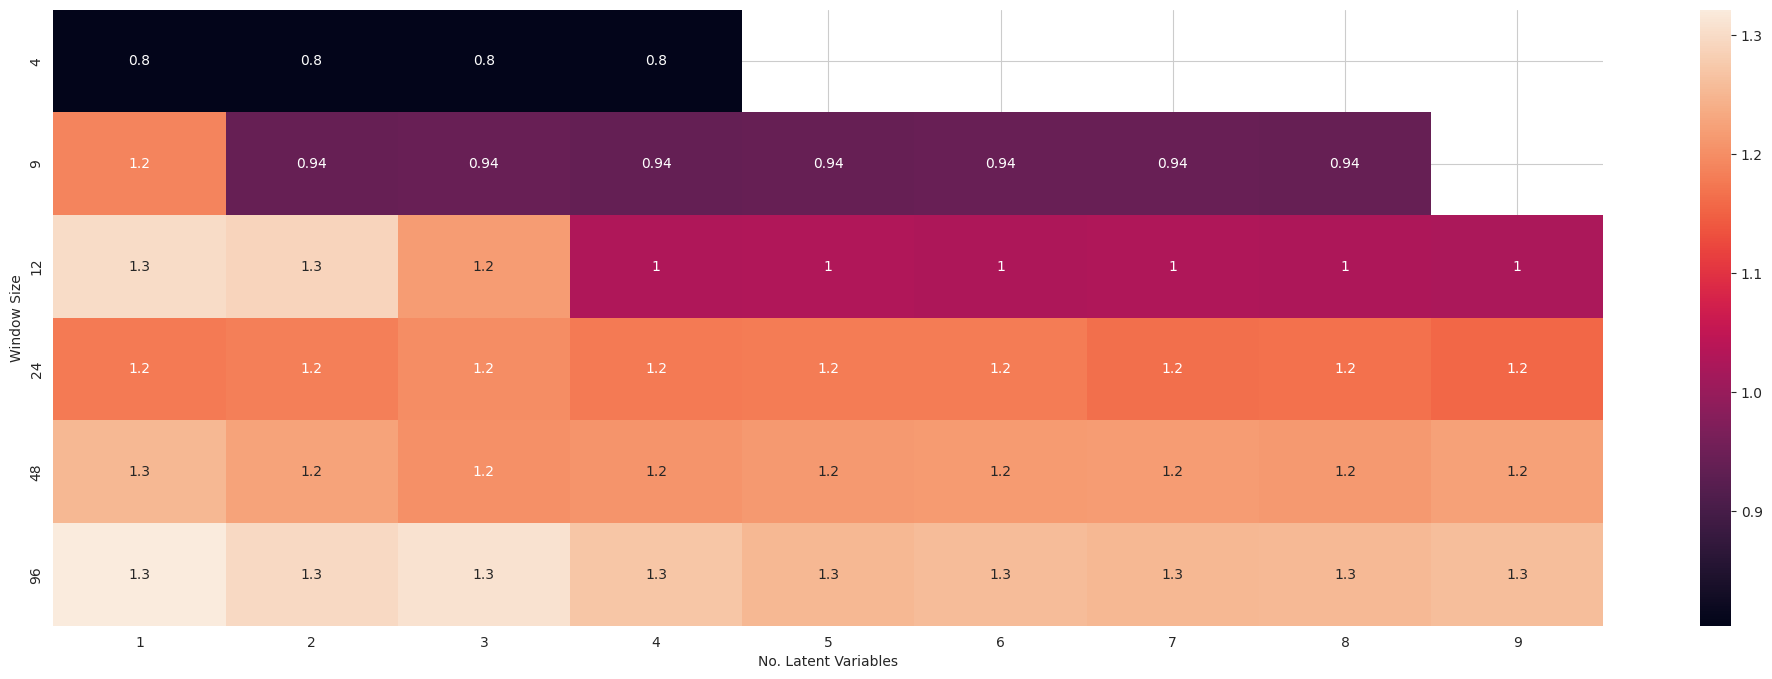

In [236]:
metrics = np.zeros((len(windows), max_comp_num - 1))

outliers = []
for model in models:
    metric = np.array(model.test_metrics[0])
    problem_ids = np.where(metric > 100)
    metrics[windows.index(model.window_size), model.num_components - 1] = np.mean(metric)

fig, _ = plt.subplots(figsize=(25, 8))
ax = heatmap(metrics, annot=True, xticklabels=range(1, max_comp_num), yticklabels=(np.array(windows) * 0.75).astype(int))
ax.set(ylabel="Window Size", xlabel="No. Latent Variables")



In [218]:
coeffs = []
for model in models[47].model[:]:
    try:
        coeffs.append(np.array(model.coeff_pls[:, 2].squeeze()))
    except:
        coeffs.append(coeffs[-1])

In [ ]:
print(len(coeffs))

In [ ]:
import matplotlib.pyplot as plt

color = [np.random.choice(range(256), size=3) / 256. for _ in range(df_array.shape[1] - 1)]

fig, ax = plt.subplots(figsize=(25, 8))
ax.bar(range(1, np.mean(np.array(coeffs), axis=0).shape[0] + 1), 
        np.mean(np.array(coeffs), axis=0), color=color)
ax.set_xticks(range(1, np.mean(np.array(coeffs), axis=0).shape[0] + 1))
labels_set = list(df.columns[:-1])
labels_set.append("y")
ax.set_xticklabels(labels_set * 3, rotation="vertical")
plt.show()

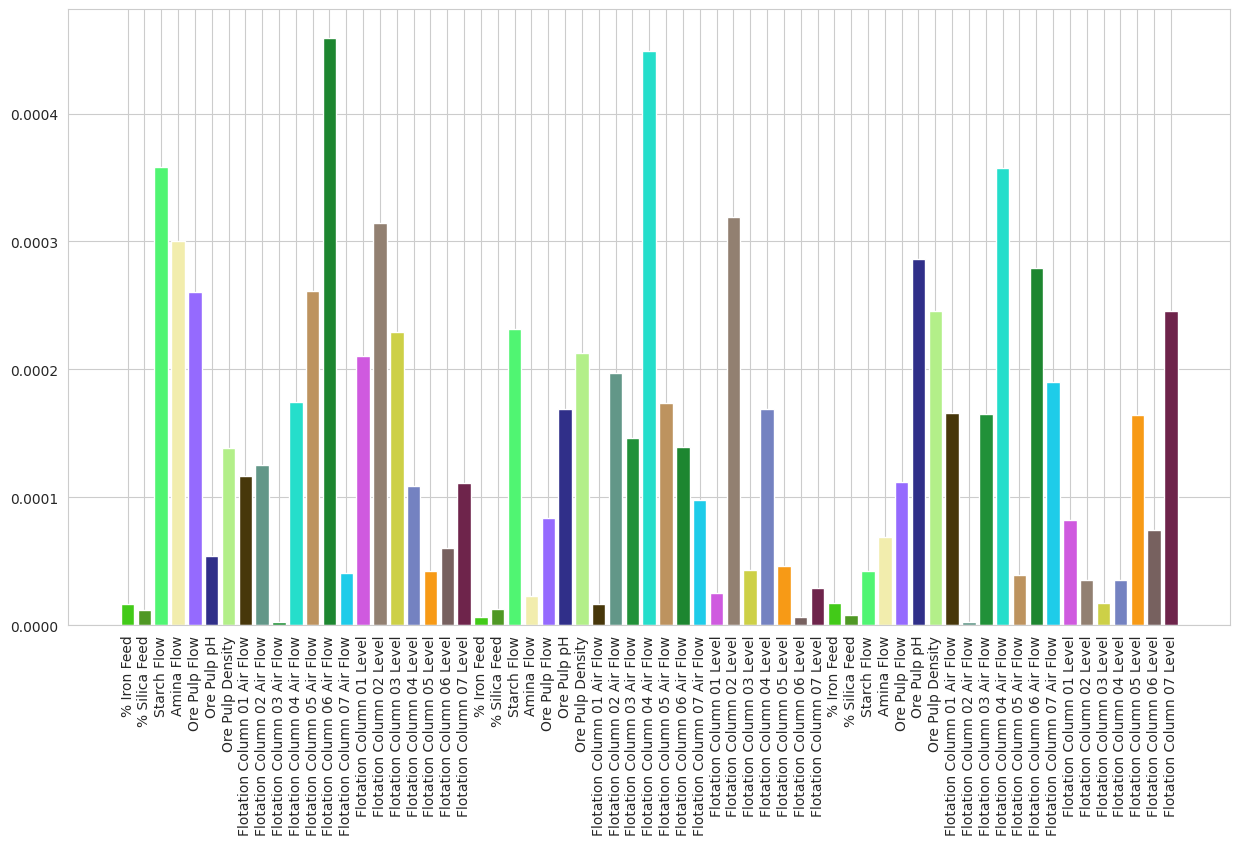

In [20]:
color = [np.random.choice(range(256), size=3) / 256. for _ in range(df_array.shape[1] - 1)]

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(range(1, np.mean(np.array(coeffs), axis=0).shape[0] + 1), 
        np.abs(np.mean(np.array(coeffs), axis=0)), color=color)
ax.set_xticks(range(1, np.mean(np.array(coeffs), axis=0).shape[0] + 1))
ax.set_xticklabels(list(df.columns[:-1]) * 3, rotation="vertical")
plt.show()